#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [1]:
# Testing if integration works

In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [10]:
file_name = './data/knee/singlecoil_train/file1001061.h5'
hf = h5py.File(file_name)

In [11]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPD_FBK', 'max': 0.0005416377344162283, 'norm': 0.2291047393075639, 'patient_id': '2980b0043beadc5be9d13fc2cdb25aac41ca319af007c9ec23502485616c3b73'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [12]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(35, 640, 368)


In [ ]:
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume
print(slice_kspace.shape)

Let's see what the absolute value of k-space looks like:

In [27]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

def show_single_coil(data, cmap=None):
    fig = plt.figure()
    plt.subplot(1, 1, 1)
    plt.imshow(data, cmap=cmap)

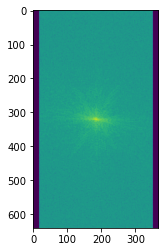

In [28]:
# show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10
show_single_coil(np.log(np.abs(slice_kspace) + 1e-9))

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [29]:
import fastmri
from fastmri.data import transforms as T

In [30]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

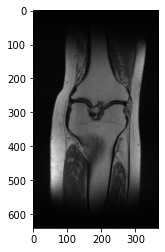

In [31]:
# show_coils(slice_image_abs, [0, 5, 10], cmap='gray')
show_single_coil(slice_image_abs, cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [32]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

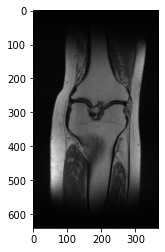

In [35]:
# plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')
plt.imshow(np.abs(slice_image_abs.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [105]:
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc
mask_func = EquispacedMaskFunc(center_fractions=[0.04], accelerations=[4])  # Create the mask function object

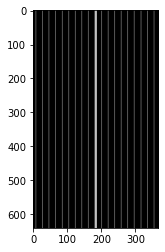

In [106]:
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
mask_img = np.zeros((640, 368))
mask_img[:,] = mask.numpy()[0].T[0]
plt.imshow(mask_img, cmap='gray')

Let's see what the subsampled image looks like:

In [77]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

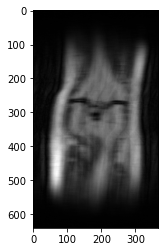

In [61]:
# plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')
plt.imshow(np.abs(sampled_image_abs.numpy()), cmap='gray')